<a href="https://colab.research.google.com/github/MiNeves00/ReinforcementLearning/blob/main/deep-rl-course/Q_Learning_with_Taxi_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning with Taxi-v3 🚕
In this notebook, you'll implement a **Q-Learning** taxi that will need to learn to **navigate in a city to transport its passengers from point A to point B.** 🚖

## Prerequisites 🏗️
Before diving into the notebook **you need to understand**:
- The foundations of Reinforcement learning (MC, TD, Rewards hypothesis...). 

[📜 Read the chapter](https://medium.com/@thomassimonini/an-introduction-to-deep-reinforcement-learning-17a565999c0c?source=friends_link&sk=1b1121ae5d9814a09ca38b47abc7dc61) 

[📹 Watch the chapter](https://youtu.be/q0BiUn5LiBc)

- Q-Learning Part 1

[📜 Read the chapter](https://medium.com/@thomassimonini/q-learning-lets-create-an-autonomous-taxi-part-1-2-3e8f5e764358)

[📹 Watch the chapter](https://youtu.be/230bR2DrbdE)

- Q-Learning Part 2

[📜 Read the chapter]()




# This is a notebook from [Deep Reinforcement Learning Course v2.0 with Tensorflow and PyTorch](https://simoninithomas.github.io/deep-rl-course/)
<img src="https://simoninithomas.github.io/deep-rl-course/assets/img/environments.jpg" alt="Deep Reinforcement Course v2.0"/>
<br>

Deep RL Course v2.0 is a **free course in Deep Reinforcement Learning from beginner to expert**.

You'll build a **strong professional portfolio** by implementing awesome agents (Q-Learning, Deep Q-Learning, Policy Gradients, A2C, PPO, SAC...) **with Tensorflow and PyTorch that learns to play Space invaders👾, Doom👹, Minecraft, Starcraft, Sonic the hedgehog and more!** 

In addition to the foundation's syllabus, we add a **new series on building AI for video games in Unity and Unreal Engine** using Deep RL.

## 📚 [Check the syllabus](https://simoninithomas.github.io/Deep_reinforcement_learning_Course/)
## 👨‍💻 [Check the Repository](https://github.com/simoninithomas/Deep_reinforcement_learning_Course)
## 📹 [Subscribe to our YouTube Channel](https://www.youtube.com/c/thomassimonini?sub_confirmation=1) 


## Any questions ?
<p> Feel free to ask me: 📧: <a href="mailto:simonini.thomas.pro@gmail.com">simonini.thomas.pro@gmail.com</a>  </p>

## Keep in Touch  🙌

Follow me on [Twitter @ThomasSimonini](https://twitter.com/ThomasSimonini)

[Subscribe to our Youtube Channel](https://www.youtube.com/c/thomassimonini?sub_confirmation=1) 



### Step 0: Install and import the libraries 📚
We will use different libraries:
- `Numpy`: For handling our Q-table.
- `OpenAI Gym`: Contains our 🚕 environment (Taxi-v3).
- `Random`: To generate random numbers (that will be useful for Epsilon-Greedy Policy).


In [2]:
!pip install numpy
!pip install gym

In [3]:
import numpy as np
import gym
import random

## Step 1: Create the environment 🕹️
- Here we'll create the Taxi-v3 environment 🚕. 

[Environment]

Our environment looks like this: 
- It's a **5x5 grid world**
- Our 🚕 is spawned **randomly** in a square. 
- The passenger is **spawned randomly in one of the 4 possible locations** (R, B, G, Y) and wishes to go in one of the **4 possibles locations too**.

The reward system:
- -1 for each timestep
- +20 for successfully deliver the passenger
- -10 for illegal actions (pickup or putdown the passenger at the outside of the destination).

In [4]:
env = gym.make("Taxi-v3")
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Step 2: Create the Q-table and initialize it 🗄️
- Now, we'll create our Q-table, to know how much rows (states) and columns (actions) we need to know the **action_space and the observation_space**.
- OpenAI Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`

In [5]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")
action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  500  possible states
There are  6  possible actions


In [6]:
# Create our Q table
Q = np.zeros((state_space, action_space))
print(Q)
print(Q.shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
(500, 6)


## Step 3: Define the hyperparameters ⚙️
- Here, we'll specify the hyperparameters

In [7]:
total_episodes = 25000 # train episodes
total_test_episodes = 100 # test episodes
max_steps = 200 # max steps per episode

learning_rate = 0.01
gamma = 0.99 # discount rate

# Exploration vs Explotation
epsilon = 1.0 # Exploration rate
max_epsilon = 1.00
min_epsilon = 0.001
decay_rate = 0.01


## Step 4: Define the epsilon-greedy policy 🤖

Epsilon-Greedy is a policy that handles the exploration/[exploitation trade-off](https://medium.com/@thomassimonini/an-introduction-to-deep-reinforcement-learning-17a565999c0c?source=friends_link&sk=1b1121ae5d9814a09ca38b47abc7dc61).

### The idea

Epsilon Greedy:

- *With probability 1 - ɛ* : we do **exploitation** (aka our agent selects the action with the highest state-action pair value).

- *With probability ɛ*: we do **exploration** (trying random action).

And as the training goes, **we progressively reduce the epsilon value** since we will **need less and less exploration and more exploitation**.

In [8]:
def epsilon_greedy_policy(Q,state):
  # if rand > epsilon --> explotation
  if(random.uniform(0,1) > epsilon):
    action = np.argmax(Q[state])
  else:
    action = env.action_space.sample()

  return action

## Step 5: Define the Q-Learning algorithm and train our agent 🧠
- Now we implement the Q learning algorithm:
[Q-Learning]

In [14]:
rewards = []

for episode in range(total_episodes):
  state = env.reset()
  step = 0
  done = False
  total_rewards = 0

  epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

  for step in range(max_steps):
    action = epsilon_greedy_policy(Q,state)

    new_state,reward,done,info = env.step(action)
    total_rewards += reward

    Q[state][action] = Q[state][action] + learning_rate*(reward+gamma*np.max(Q[new_state]) - Q[state][action])

    if done:
      rewards.append(total_rewards)
      break

    state = new_state

Score over time: 1735.97
[-830, -722, -731, -731, -731, -920, -776, -794, -785, -767, -202, -119, -181, -302, -742, -613, -309, -695, -639, -695, -179, -52, -406, -244, -187, -384, -402, -147, -53, -157, -307, -214, -536, -102, -107, -49, -89, 1, -121, -190, -175, -144, -173, -168, -51, -82, -119, -37, -55, -56, -317, -74, -57, -204, -59, -131, -106, -149, -72, -14, -139, -108, -37, -56, -41, -42, -66, -75, -19, -51, -48, -40, -43, -48, -3, -29, -52, -4, -15, -52, -24, -14, -68, -20, 5, -47, -59, -25, 1, -8, 7, -41, -64, -35, -16, -8, -74, -36, -46, -8, 9, -31, -33, -27, -2, -17, -27, 11, -27, -9, 4, 7, -15, -25, -19, -8, -6, 8, 8, -13, -24, -7, -24, -20, -3, -44, -47, -26, 7, -71, 1, -6, -31, -50, 7, -19, 1, 4, -16, -40, -15, -1, -19, -17, -10, -33, 1, -14, -15, 2, -6, 10, -16, 6, -33, 8, 9, 4, -4, 11, 1, -16, 11, -4, 10, 8, 3, 7, -11, 5, -3, -27, -10, 4, -27, -5, 5, -20, 1, 1, -6, 9, 6, 3, 9, 0, -15, 1, -4, 7, 15, 5, 1, 1, 5, -8, 4, 4, 9, -18, 11, -6, 11, 6, 12, 11, -16, -7, 5, 11, 6


## Step 6: Let's watch our autonomous 🚖 
- By running this cell, you'll see your smart taxi agent.




In [16]:
def createList(n):
    lst = []
    for i in range(n+1):
        lst.append(i)
    return(lst)


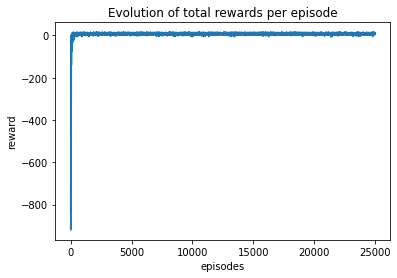

Score over time: 1735.97
[-830, -722, -731, -731, -731, -920, -776, -794, -785, -767, -202, -119, -181, -302, -742, -613, -309, -695, -639, -695, -179, -52, -406, -244, -187, -384, -402, -147, -53, -157, -307, -214, -536, -102, -107, -49, -89, 1, -121, -190, -175, -144, -173, -168, -51, -82, -119, -37, -55, -56, -317, -74, -57, -204, -59, -131, -106, -149, -72, -14, -139, -108, -37, -56, -41, -42, -66, -75, -19, -51, -48, -40, -43, -48, -3, -29, -52, -4, -15, -52, -24, -14, -68, -20, 5, -47, -59, -25, 1, -8, 7, -41, -64, -35, -16, -8, -74, -36, -46, -8, 9, -31, -33, -27, -2, -17, -27, 11, -27, -9, 4, 7, -15, -25, -19, -8, -6, 8, 8, -13, -24, -7, -24, -20, -3, -44, -47, -26, 7, -71, 1, -6, -31, -50, 7, -19, 1, 4, -16, -40, -15, -1, -19, -17, -10, -33, 1, -14, -15, 2, -6, 10, -16, 6, -33, 8, 9, 4, -4, 11, 1, -16, 11, -4, 10, 8, 3, 7, -11, 5, -3, -27, -10, 4, -27, -5, 5, -20, 1, 1, -6, 9, 6, 3, 9, 0, -15, 1, -4, 7, 15, 5, 1, 1, 5, -8, 4, 4, 9, -18, 11, -6, 11, 6, 12, 11, -16, -7, 5, 11, 6

In [26]:
# Visualize Score over time when training
import matplotlib.pyplot as plt

x_axis = createList(total_episodes-1)
y_axis = rewards
#plt.yscale('log')
#plt.xscale('log')
plt.plot(x_axis, y_axis)
 
# naming the x axis
plt.xlabel('episodes')
# naming the y axis
plt.ylabel('reward')
 
# giving a title to my graph
plt.title('Evolution of total rewards per episode')
 
# function to show the plot
plt.show()

print("Score over time: " + str(sum(rewards)/total_test_episodes))
print(rewards)

In [11]:
import time
rewards = []
frames = []

for episode in range(total_test_episodes):
  state = env.reset()
  step = 0
  done = False
  total_rewards = 0
  print("************************************************")
  print("Episode ", episode)
  for step in range(max_steps):
    env.render()
    action = np.argmax(Q[state][:])
    new_state, reward, done, info = env.step(action)
    total_rewards += reward

    if done:
      rewards.append(total_rewards)
      break
    state = new_state

env.close()
print("Score over time: " + str(sum(rewards)/total_test_episodes))

A saída de streaming foi truncada nas últimas 5000 linhas.
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: